In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import sklearn.model_selection as skm
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import sklearn.preprocessing as skp
import librosa
import import_ipynb
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
GTZAN_DIR = '/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/GTZAN_data/'
features = pd.read_csv(GTZAN_DIR+"features_30_sec.csv")

In [3]:
df = features[['filename','label']].copy()
df['MFCCs'] = None


In [4]:
df.head()

,filename,label,MFCCs
0,blues.00000.wav,blues,None
1,blues.00001.wav,blues,None
2,blues.00002.wav,blues,None
3,blues.00003.wav,blues,None
4,blues.00004.wav,blues,None


In [6]:
for i in tqdm(range(features.shape[0])):
  
  try:
    track_id = int(features['filename'][i].split('.')[1])
          
    filename = utils.get_audio_path(GTZAN_DIR, track_id, features['label'][i])

    x, sr = librosa.load(filename, mono=True, duration = 15)

    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    del stft
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=30)

    df.at[i, 'MFCCs'] = mfcc

  except Exception as e:
        print('{}: {}'.format(i, repr(e)))


 55%|█████▌    | 553/1000 [00:08<00:05, 82.04it/s]/Users/nkkaushal/Documents/Fall22/ECS_271/Project/venv/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 56%|█████▌    | 562/1000 [00:08<00:05, 77.87it/s]

554: NoBackendError()


100%|██████████| 1000/1000 [00:14<00:00, 67.72it/s]


In [25]:
df = df.dropna()

In [33]:
X = df['MFCCs'][:1000]
Y = df['label'][:1000]
scaler = skp.StandardScaler(copy=False)
genre_list = Y.unique()
genre_dict = {}
for i in range(genre_list.shape[0]):
    genre_dict[genre_list[i]] = i

/var/folders/v3/49xwmkw17sjdq3cp1fp4wptr0000gn/T/ipykernel_21972/3696471984.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X = df['MFCCs'][:1000]
/var/folders/v3/49xwmkw17sjdq3cp1fp4wptr0000gn/T/ipykernel_21972/3696471984.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Y = df['label'][:1000]


In [34]:
def one_hot(Y_genre_strings):
    y_one_hot = np.zeros((Y_genre_strings.shape[0], len(genre_list)))
    for i, genre_string in enumerate(Y_genre_strings):
        index = genre_dict[genre_string]
        y_one_hot[i, index] = 1
    return y_one_hot

In [35]:
X = X.apply(lambda x : x.reshape(x.shape[1], x.shape[0]))

In [36]:
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y, test_size=0.3, random_state=42)

In [37]:
X_train_1d = np.stack(X_train, axis = 0)
X_test_1d = np.stack(X_test, axis = 0)
y_train_1d = one_hot(Y_train)
y_test_1d = one_hot(Y_test)

In [39]:
SEQUENCE_MODEL = 'cnn_lstm_sequence.h5'
EPOCHS = 100
LR = 0.00025
BATCH_SIZE = 16
FILTER = 32
KERNEL_SIZE = 4
INPUT_SHAPE = (X_train_1d.shape[1], X_train_1d.shape[2]) # input shape of 1d ccn = (# samples, # timesteps, # features)
POOL_SIZE = 2
CONV_DROPOUT = 0.25
FC_DROPOUT = 0.5

In [40]:
model = Sequential()

model.add(Conv1D(FILTER, KERNEL_SIZE, input_shape = INPUT_SHAPE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(Conv1D(FILTER, KERNEL_SIZE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(Conv1D(FILTER, KERNEL_SIZE, padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(CONV_DROPOUT))
model.add(AveragePooling1D(pool_size = POOL_SIZE))

model.add(Flatten())

model.add(Dense(50, activation = 'relu'))
model.add(Dropout(FC_DROPOUT))
model.add(Dense(10, activation = 'softmax'))

opt = Adam(lr = LR)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-30 04:31:12.598414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 04:31:12.598967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 646, 32)           3872      
                                                                 
 batch_normalization (BatchN  (None, 646, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 646, 32)           0         
                                                                 
 dropout (Dropout)           (None, 646, 32)           0         
                                                                 
 average_pooling1d (AverageP  (None, 323, 32)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 323, 32)           4

/Users/nkkaushal/Documents/Fall22/ECS_271/Project/venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
history = model.fit(X_train_1d,
                    y_train_1d,
                    epochs = EPOCHS,                  
                    verbose = 2,
                    validation_data = (X_test_1d, y_test_1d))

Epoch 1/100


2022-11-30 04:31:18.500864: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 04:31:19.054680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-30 04:31:22.341718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 - 4s - loss: 2.4873 - accuracy: 0.1144 - val_loss: 2.2509 - val_accuracy: 0.1233 - 4s/epoch - 189ms/step
Epoch 2/100
22/22 - 1s - loss: 2.2199 - accuracy: 0.1874 - val_loss: 2.1973 - val_accuracy: 0.1567 - 573ms/epoch - 26ms/step
Epoch 3/100
22/22 - 1s - loss: 2.1475 - accuracy: 0.2389 - val_loss: 2.1367 - val_accuracy: 0.2533 - 598ms/epoch - 27ms/step
Epoch 4/100
22/22 - 1s - loss: 2.0803 - accuracy: 0.2661 - val_loss: 2.0720 - val_accuracy: 0.2333 - 584ms/epoch - 27ms/step
Epoch 5/100
22/22 - 1s - loss: 2.0040 - accuracy: 0.3076 - val_loss: 2.0425 - val_accuracy: 0.2300 - 617ms/epoch - 28ms/step
Epoch 6/100
22/22 - 1s - loss: 1.9263 - accuracy: 0.3090 - val_loss: 1.9491 - val_accuracy: 0.2600 - 565ms/epoch - 26ms/step
Epoch 7/100
22/22 - 1s - loss: 1.8149 - accuracy: 0.3691 - val_loss: 1.9190 - val_accuracy: 0.2533 - 593ms/epoch - 27ms/step
Epoch 8/100
22/22 - 1s - loss: 1.7995 - accuracy: 0.3376 - val_loss: 1.8516 - val_accuracy: 0.2533 - 640ms/epoch - 29ms/step
Epoch 9/100
22

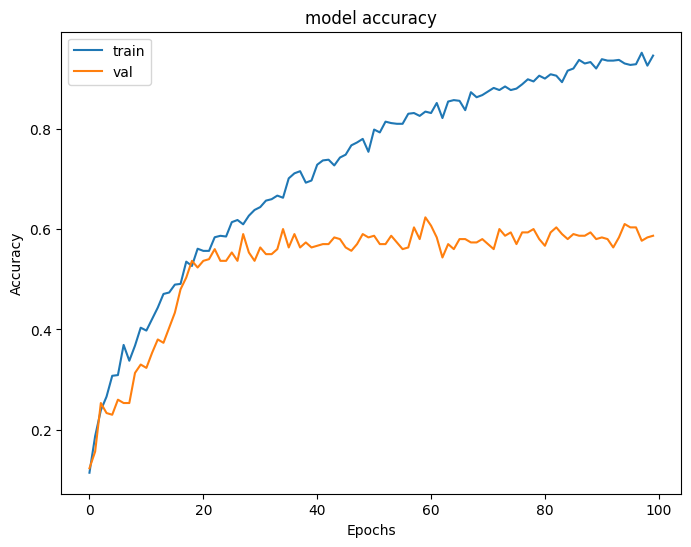

In [42]:
plt.figure(figsize = (8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('model accuracy')
plt.legend(['train','val'])

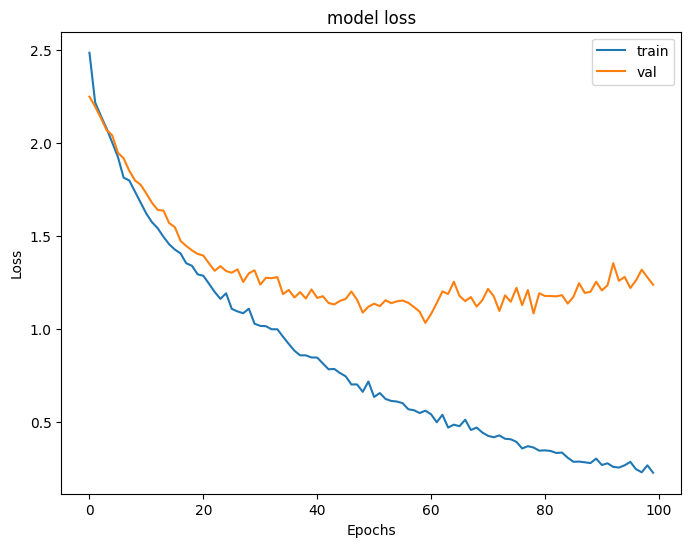

In [43]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('model loss')
plt.legend(['train','val'])